<a href="https://colab.research.google.com/github/Computational-physics-with-learning/pde-model-discovery/blob/main/pysindy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Misc Set-up
!wget -nc https://github.com/Computational-physics-with-learning/PINNs/raw/main/data/image_0001.jpg
!wget -nc https://github.com/Computational-physics-with-learning/PINNs/raw/main/code/utils.py
!wget -nc https://github.com/Computational-physics-with-learning/PINNs/raw/main/code/torch_utils.py

!pip install pysindy

!git clone https://github.com/dynamicslab/pysindy.git
%cd pysindy
!pip install .
%cd ..

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
# from pysindy.utils import linear_damped_SHO, cubic_damped_SHO, linear_3D, hopf, lorenz
from numpy.fft import fft2, ifft2
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from torch_utils import (pt, time, str2loss, DenseNN, Basic_model, 
    to_device, from_device, plotHistory)
from numba import jit, prange
from PIL import Image, ImageOps

import pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# [Sparse Identification of Nonlinear Dynamical systems (SINDy)](https://www.pnas.org/doi/full/10.1073/pnas.1517384113)
[*Github repo*](https://github.com/dynamicslab/pysindy)
## Motivation
"Understanding dynamic constraints and balances in nature has facilitated rapid development of knowledge and enabled technology, including aircraft, combustion engines, satellites, and electrical power." (Brunton et al, 2016)
- Consider the problem of dynamical system discovery in the context of sparse regression and compressed sensing
- Emphasizes parsimony (Occam's razor) as seen in physics
- Approach the problem considering measurements of data at different points in time

### Why no symbolic regression?
- Symbolic regression via genetic programming
  - Pros - balances complexity of model/number of terms with model accuracy to extract (symbolic) expressions from data
  - Cons - Computationally expensive, does not scale well, potentially prone to overfitting

## How it works
Consider $\frac{d}{dt}\mathbf{x}(t) = f(\mathbf{x}(t))$

>$\mathbf{x}(t) = [x_{1}(t),x_{2}(t),...x_{n}(t)]^{\top}$ are a set of measurements of the state of the physical system at time $t$

>$\mathbf{x}(t)\in \mathbb{R} ^{n}$

>$f(\mathbf{x}(t))$ is the (nonlinear) equation governing the dynamics of some physical system

- Target function $f$ is typically very sparse in the space of possible functions (only a few terms)
- Construct a library of candidate nonlinear functions
    - Eg.: constant, polynomial, and trig terms
- Determine which candidate functions are active/exist in $f$ via sparse regression in the presence of noise

Then:

$$
	X = \begin{bmatrix}
		x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
		x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
		\vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
	\end{bmatrix}
$$

$$
	\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
		\dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
		\vdots & \vdots & & \vdots \\
		\dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
	\end{bmatrix}
$$

- note that $\dot{\mathbf{x}}$ may be measured or calculated

The library is defined (either by user or from a predefined library in the package, or both)

$$
	\Theta(X) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
		\mid & \mid & & \mid 
	\end{bmatrix}.
$$

$f$ is assumed to be very sparse compared to the space of potential functions. Given a set of basis functions, we can write it as a linear combination with most coefficients being zero:

$$ f_i(x) = \xi_1\theta_1(x) + \xi_2\theta_2(x) + \dots + \xi_k\theta_k(x) $$

These coefficient vectors can be represented as

$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

and are computed for via

$$ \dot X \approx \Theta(X)\Xi. $$

- $\xi_i$ gives the coefficients for $f_i$
- derivatives of $x$ are approximated numerically for this approximation problem
- $\Xi$ is solved via a sparse regression algorithm

File ‘Fig1.png’ already there; not retrieving.



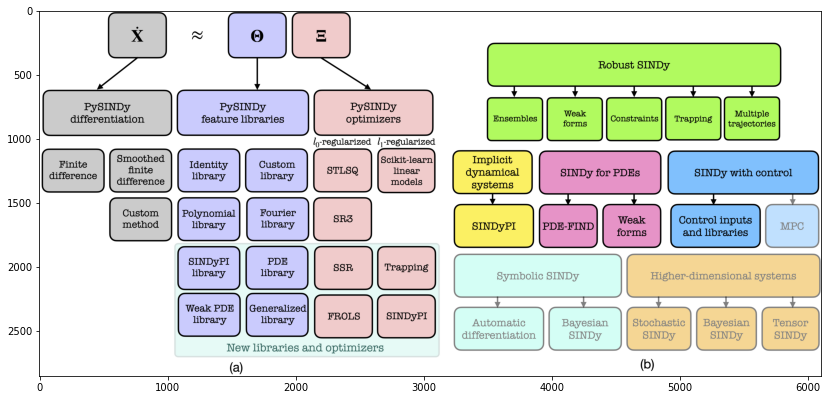

In [ ]:
#@title pySINDy and the equation $\dot X \approx \Theta(X)\Xi$

!wget -nc https://raw.githubusercontent.com/dynamicslab/pysindy/master/docs/JOSS2/Fig1.png
tmp = Image.open('Fig1.png')
plt.figure(figsize=(14,10))
imgplot = plt.imshow(tmp)
plt.show()

## Libraries
- Identity Library
- PDE Library
  - 
- Polynomial Library
- Fourier Library
- SindyPI Library
  - *Deprecated and replaced by both PDE and weakPDE libraries
- Weak PDE Library
  - Assumes the function $f(x)$ integrated against derivatives of the test function $d\phi(x)$ is linear between grid points provided by the data. $f(x)\times d\phi(x)$ is approximated as a piecewise polynomial

## Sparse Regression Algorithms

- Sequentially thresholded least squares algorithm (STLSQ)
$$||y-Xw||^{2}_{2} + \alpha||w||^{2}_{2}$$
  - Optimized using iterative least squares
  - Masks out $w$ values below a (user-defined) threshold
- Sparse relaxed regularized regression (SR3)
  - First related objective function:
$$0.5||y-Xw||^{2}_{2} + \lambda R(w) + \frac{1}{2\eta}||Pw-A||^{2}_{2} + \delta_{0}(Cw-d) + \delta_{\Lambda}(A)$$
  - Second related objective function
$$0.5||y-Xw||^{2}_{2} + \lambda R(w) + \frac{1}{2\eta}||Pw-A||^{2}_{2} + \delta_{0}(Cw-d) + \frac{1}{2\eta}\text{maximum eigenvalue}(A)$$
  - One of them are minimized
  - $R(w)$ is a convex regularization function
  - $\delta_{0}$ is an indicator function providing a hard contraint of $CW = d$
  - $\delta_{\Lambda}$ projects matrix $A$ onto the space of negative definite matrices
  - References: [Kaptanoglu et al. 2021](https://journals.aps.org/prfluids/abstract/10.1103/PhysRevFluids.6.094401), [Zheng et al. 2018](https://ieeexplore.ieee.org/document/8573778), [Champion et al. 2020](https://ieeexplore.ieee.org/document/9194760)
- Forward Regression Orthogonal Least-Squares (FROLS)
$$||y-Xw||^{2}_{2} + \alpha ||w||^{2}_{2}$$
  - Greedy algorithm which minimizes the above function by iteratively selecting the most correlated function in the library
  - [Billings et al. 2013](https://www.wiley.com/en-us/Nonlinear+System+Identification%3A+NARMAX+Methods+in+the+Time%2C+Frequency%2C+and+Spatio+Temporal+Domains-p-9781119943594)

File ‘Fig3.png’ already there; not retrieving.



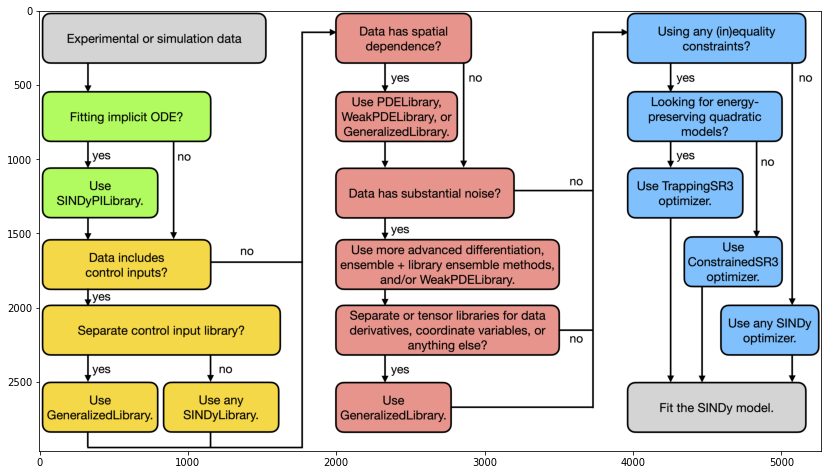

In [ ]:
#@title Flowchart of pySINDy options
!wget -nc https://raw.githubusercontent.com/dynamicslab/pysindy/master/docs/JOSS2/Fig3.png
tmp = Image.open('Fig3.png')
plt.figure(figsize=(14,10))
imgplot = plt.imshow(tmp)
plt.show()

File ‘optimizer_summary.jpg’ already there; not retrieving.



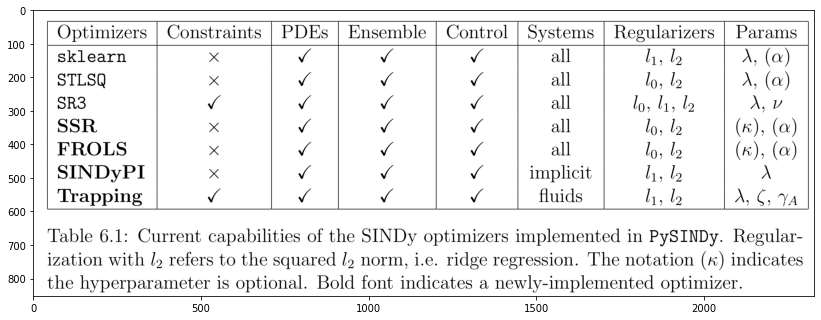

In [ ]:
#@title Outdated, but a good quick table of functionalities. Keep in mind this does not include the new PDE-FIND method which effectively replaces SINDyPI.
!wget -nc https://pysindy.readthedocs.io/en/latest/_images/optimizer_summary.jpg
tmp = Image.open('optimizer_summary.jpg')
plt.figure(figsize=(14,10))
imgplot = plt.imshow(tmp)
plt.show()

###$l_0$
- sparser solutions
- tends to further lead to higher performance and more stable models, since there are no small-coefficient terms that can become active with new initial conditions or parameter regimes
- norm transforms the SINDy regression into a nonconvex problem, for which only local convergence guarantees can be provided

###$l_1$
- can be used with (in)equality constraints, problem is convex so have global convergence guarantees
- sparsity is harder to enforce, and the  norm can systematically bias the system towards certain solutions

###$l_2$
- ridge regression

#Notable papers
- Original paper [Brunton et al. 2016](https://www.pnas.org/doi/abs/10.1073/pnas.1517384113)
- SINDy with control [Brunton et al. 2016](https://www.sciencedirect.com/science/article/pii/S2405896316318298)
- Unified sparse optimization framework for parsimony [Champion et al. 2020](https://ieeexplore.ieee.org/document/9194760)
- Parallel implicit SINDy (SINDy-PI) [Kaheman et al. 2020](https://royalsocietypublishing.org/doi/10.1098/rspa.2020.0279)
- PDE-FIND, data-driven discovery of PDEs [Rudy et al. 2017](https://www.science.org/doi/10.1126/sciadv.1602614)
- Global stability in quadratic nonlinear dynamics [Kaptanoglu et al. 2021](https://journals.aps.org/prfluids/abstract/10.1103/PhysRevFluids.6.094401)
- PySINDy package [de Silva et al. 2020](https://arxiv.org/abs/2004.08424)
- Ensemble-SINDy [Fasel et al. 2022](https://royalsocietypublishing.org/doi/full/10.1098/rspa.2021.0904)
- Review of Explainable ML for Science [Roscher et al. 2020](https://ieeexplore.ieee.org/abstract/document/9007737)
- Model predictive control for advanced process control [Kaiser et al. 2018](https://royalsocietypublishing.org/doi/abs/10.1098/rspa.2018.0335)

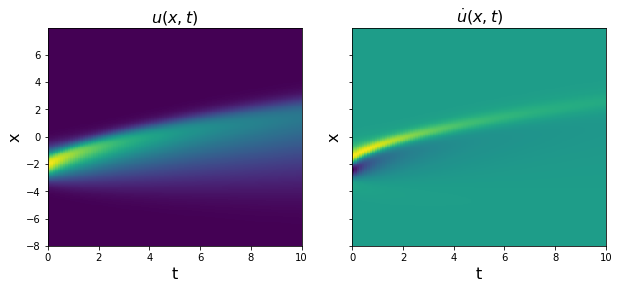

In [ ]:
#@title Loading and plotting Burgers (1D)

# Load data from .mat file
data = loadmat('pysindy/examples/data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(t), 1)
u_dot = u_dot.reshape(len(x), len(t), 1)

$u_{t} = -uu_{x} + 0.1u_{xx}$

In [ ]:
#@title Comparison of different sparse regression models to demonstrate SINDy

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=2,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=0.5, max_iter=10000, tol=1e-15,
    thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual",
                   normalize_columns=True,
                   kappa=1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
SR3 model, L0 norm: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
SR3 model, L1 norm: 
(x0)' = -0.001 x0_1 + 0.100 x0_11 + -1.000 x0x0_1
SSR model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
SSR (metric = model residual) model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
FROLs model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1


# Let's add 20% noise, as per the paper...

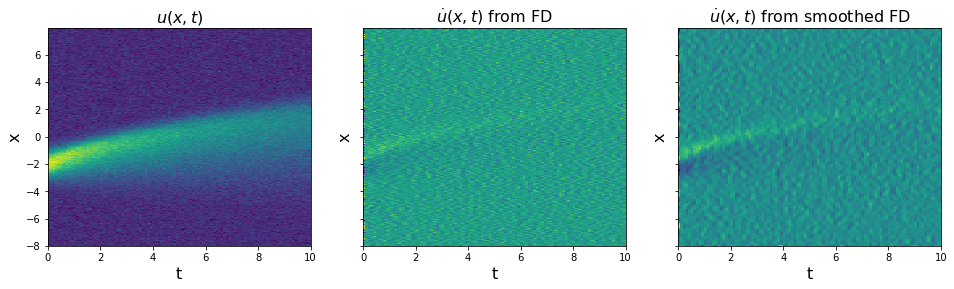

In [ ]:
#@title Plot $u$, $\dot{u}$, and smoothed $\dot{u}$

# Not efficient, but just reload to save RAM
data = loadmat('pysindy/examples/data/burgers.mat')
t = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]

rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
u = u + np.random.normal(0, rmse / 5.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$ from FD', fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$ from smoothed FD', fontsize=16)
plt.show()

u = np.reshape(u, (len(x), len(t), 1))

In [ ]:
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=2, spatial_grid=x,
                        include_bias=False,
                        is_uniform=True)

print('STLSQ model: ')
optimizer = ps.STLSQ(
    threshold=0.1,
    alpha=1e-2,
    normalize_columns=True,
    max_iter=5)
# threshold of 2 was too large and eliminated all parameters
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = 0.130 x0 + -0.362 x0x0 + -0.204 x0x0_1 + -0.104 x0x0x0_1 + -0.003 x0x0_11 + 0.004 x0x0x0_11


In [ ]:
#@title Playing around with the SR3 model to demonstrate some options
print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=0.05, # threshold of 2 was too large and eliminated all parameters
    max_iter=500,
    tol=1e-8,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=0.06, # threshold of 2 was too large and eliminated all parameters
    max_iter=800,
    tol=1e-8,
    thresholder="l1",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

SR3 model, L0 norm: 
(x0)' = 0.129 x0 + -0.362 x0x0 + 0.001 x0_1 + -0.211 x0x0_1 + -0.098 x0x0x0_1 + -0.003 x0x0_11 + 0.004 x0x0x0_11
SR3 model, L1 norm: 
(x0)' = 0.130 x0 + -0.362 x0x0 + -0.204 x0x0_1 + -0.104 x0x0x0_1 + -0.003 x0x0_11 + 0.004 x0x0x0_11


In [ ]:
#@title Let's now see how the weak form PDE library performs...
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(library_functions=library_functions,
                            function_names=library_function_names,
                            derivative_order=2,
                            spatiotemporal_grid=XT,
                            is_uniform=True, K=1000,
                            )

print('Weak form STLSQ model: ')
optimizer = ps.STLSQ(
    threshold=0.1,
    alpha=1e-2,
    normalize_columns=True,
    max_iter=5)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('Weak form SR3 model, L0 norm')
optimizer = ps.SR3(
    threshold=0.1, thresholder='l0',
      tol=1e-8,
      normalize_columns=True,
      max_iter=1000
      )
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

print('Weak form SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=0.1,
    max_iter=1000,
    tol=1e-8,
    thresholder="l1",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

Weak form STLSQ model: 
(x0)' = 0.085 x0_11 + -1.020 x0x0_1
Weak form SR3 model, L0 norm
(x0)' = 0.085 x0_11 + -1.020 x0x0_1
Weak form SR3 model, L1 norm: 
(x0)' = -0.150 x0_1 + -0.601 x0x0_1


We now consider the curvature-flow:
$$ \partial_t u = |\nabla_{x,y} u|\kappa(u)^{\frac13} = (\partial_yu^2 \partial_{xx}u - 2\partial_xu \partial_yu \partial_{xy}u + \partial_xu^2 \partial_{yy}u)^{\frac13}
$$
with initial condition $u(0,x,y) = \operatorname{myImg}$.

In [ ]:

#@title Utility functions for curvature flow

@jit(nopython=True, boundscheck=False, cache=True)
def pointwiseLazyRHS(u, threshold):
    ''' u.shape = (3,3), threshold = float
    returns |Du| k(u)^1/3 = (u_y^2 u_xx - 2u_x u_y u_xy + u_x^2 u_yy) ^ (1/3) 
    '''
    u_x = .5*(u[2, 1] - u[0, 1])
    u_y = .5*(u[1, 2] - u[1, 0])
    u_xx = u[2,1] - 2*u[1,1] + u[0, 1]
    u_yy = u[1,2] - 2*u[1,1] + u[1, 0]
    u_xy = .25*(u[2,2] - u[2,0] - u[0,2] + u[0,0])

    return np.cbrt(u_y**2*u_xx - 2*u_x*u_y*u_xy + u_x**2*u_yy)
    

@jit(nopython=True, boundscheck=False, cache=True, parallel=True)
def doLazystep(un, unp1, dt):
    threshold = 1e-10
    for i in prange(un.shape[0]):
        im, ip = int(max(i - 1, 0)), int(min(i + 1, un.shape[0] - 1))
        buf = np.empty((3, 3), dtype='float32')

        j = 0
        buf[0, 0], buf[0, 1], buf[0, 2] = un[im, 0], un[im, 0], un[im, 1]
        buf[1, 0], buf[1, 1], buf[1, 2] = un[i, 0], un[i, 0], un[i, 1]
        buf[2, 0], buf[2, 1], buf[2, 2] = un[ip, 0], un[ip, 0], un[ip, 1]
        unp1[i, j] = un[i, j] + dt * pointwiseLazyRHS(buf, threshold)

        j += 1
        while j < un.shape[1] - 1:
            buf[:, :2] = buf[:, 1:]
            buf[0, 2], buf[1, 2], buf[2, 2] = un[im, j + 1], un[i, j + 1], un[ip, j + 1]
            # buf[0, 0], buf[0, 1], buf[0, 2] = un[im, j - 1], un[im, j], un[im, j + 1]
            # buf[1, 0], buf[1, 1], buf[1, 2] = un[i, j - 1], un[i, j], un[i, j + 1]
            # buf[2, 0], buf[2, 1], buf[2, 2] = un[ip, j - 1], un[ip, j], un[ip, j + 1]
            unp1[i, j] = un[i, j] + dt * pointwiseLazyRHS(buf, threshold)
            j += 1

        buf[:, :2] = buf[:, 1:]  # buf[:, 2] stays the same
        unp1[i, j] = un[i, j] + dt * pointwiseLazyRHS(buf, threshold)


def computeFlow(u, dx, dt, Tmax, frames):
    step = doLazystep
    U = [u[None].copy()]
    u, v = u.copy(), u.copy()
    frame, frames = 1, np.linspace(0, Tmax, frames)

    # Very lazy hack to get minimal arange with T[-1]>=Tmax
    T = np.arange(0,Tmax+2*dt,dt)[1:]
    while T[-2]>=Tmax:
        T = T[:-1]

    for t in tqdm(T):
        step(u, v, dt / dx**(4 / 3))
        if t >= frames[frame]:
            U.append(v[None].copy())
            frame += 1
        u, v = v, u
    return u, frames, np.concatenate(U, axis=0)


def curvature_pde(X, u):  # X[i] = (t, x, y)
    # returns u_t^3 - |Du|^3 k(u) = u_t^3 - (u_y^2 u_xx - 2u_x u_y u_xy + u_x^2 u_yy)
    if X.shape[0] == 0:
        return pt.tensor(0.0)
    U = u(X)
    dU = pt.autograd.grad(U, X,  # first derivative
                          grad_outputs=pt.ones_like(U),
                          retain_graph=True,
                          create_graph=True)[0]
    U_t, U_x, U_y = dU[:, [0]], dU[:, [1]], dU[:, [2]]
    dU_x = pt.autograd.grad(U_x, X,  # second derivative
                            grad_outputs=pt.ones_like(U_x),
                            retain_graph=True,
                            create_graph=True)[0]
    U_xx, U_xy = dU_x[:, [1]], dU_x[:, [2]]
    U_yy = pt.autograd.grad(U_y, X,  # second derivative
                            grad_outputs=pt.ones_like(U_y),
                            retain_graph=True,
                            create_graph=True)[0][:, [2]]
    return U_t**3 - (U_y**2 * U_xx - 2 * U_x * U_y * U_xy + U_x**2 * U_yy)
    # return U_t - pt.pow(U_y**2 * U_xx - 2 * U_x * U_y * U_xy + U_x**2 * U_yy, 1/3)

100%|██████████| 20000/20000 [01:04<00:00, 312.23it/s]


Text(0.5, 1.0, 'Basic reconstruction')

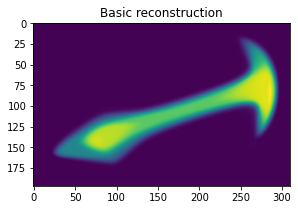

In [ ]:
#@title Computing flow with basic finite differences
myImg = Image.open('image_0001.jpg')
myImg = np.array(ImageOps.grayscale(myImg))
myImg = np.pad(myImg,5) / myImg.max()

Lx = myImg.shape[1]
Ly = myImg.shape[0]
dt = 1e-3
ops = {'dx':100/min(myImg.shape), 'Tmax':20, 'frames':12}
u, t, U = computeFlow(myImg, dt=dt, **ops)
plt.figure(figsize=(15,3))
plt.imshow(u); plt.title('Basic reconstruction')

In [ ]:
#@title Some set-up...

library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
x_uniform = np.linspace(-Lx / 2, Lx / 2, Lx + 1)
y_uniform = np.linspace(-Ly / 2, Ly / 2, Ly + 1)
x1 = x_uniform[:Lx]
y1 = y_uniform[:Ly]
x = np.linspace(0,U.shape[2]-1,U.shape[2])
y = np.linspace(0,U.shape[1]-1,U.shape[1])
t_captured = np.linspace(0,U.shape[0]-1,U.shape[0])

np.random.seed(100)
# Need to define the 2D spatial grid before calling the library
X, Y, T = np.meshgrid(x, y, t_captured, indexing='ij')
XYT = np.transpose([X, Y, T], [1, 2, 3, 0])
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    is_uniform=True,
    periodic=True,
    K=100,
    include_interaction=False
)

In [ ]:
#@title Splitting the captured timesteps into train/test

newU = np.zeros((U.shape[2], U.shape[1], U.shape[0], 1))
newU[:,:,:,0] = U.transpose()
train = np.random.choice(U.shape[0], int(U.shape[0] * 0.6), replace=False)
test = [i for i in np.arange(U.shape[0]) if i not in train]

U_dot = ps.FiniteDifference(axis=2)._differentiate(newU, dt)

U_train = newU[:, :, train, :]
U_test = newU[:, :, test, :]
U_train_dot = U_dot[:, :, train, :]
U_test_dot = U_dot[:, :, test, :]
t_train = t_captured[train]
t_test = t_captured[test]
print("train: ", train)
print("Dimensions: ", U_train.shape)
print("test: ", test)
print("Dimensions: ", U_test.shape)

train:  [ 7 10  0  2  8  4  3]
Dimensions:  (310, 197, 7, 1)
test:  [1, 5, 6, 9, 11]
Dimensions:  (310, 197, 5, 1)


In [ ]:
#@title Weak Form PDE Library result
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(newU, quiet=True)
model.print()

(x0)' = 0.026 x0 + -0.434 x0x0x0 + -0.098 x0_2 + 0.386 x0_22 + 0.481 x0_1 + 0.318 x0_12 + 0.337 x0_11 + 0.761 x0x0_2 + -0.409 x0x0x0x0_2 + 0.173 x0x0_22 + -0.102 x0x0x0x0_22 + -0.488 x0x0_1 + -1.377 x0x0x0x0_1 + -1.079 x0x0_12 + -0.511 x0x0x0x0_12 + 0.300 x0x0_11 + -0.340 x0x0x0x0_11


In [ ]:
#@title Unfortunately, the weak form model can only predict weak form outputs so for simplicity, we re-fit the model to the standard PDE library as well as a generalised library that combines the PDE library and a polynomial library

x_uniform = np.linspace(-Lx / 2, Lx / 2, Lx + 1)
y_uniform = np.linspace(-Ly / 2, Ly / 2, Ly + 1)
x1 = x_uniform[:Lx]
y1 = y_uniform[:Ly]
X1, Y1 = np.meshgrid(x1, y1)
spatial_grid = np.asarray([X1, Y1]).T

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=True
)
poly_lib = ps.PolynomialLibrary(include_bias=False)

generalized_library = ps.GeneralizedLibrary(
    [poly_lib, pde_lib],
    tensor_array=[[1,1]],
    # inputs_per_library=inputs_per_library,
)

print('STLSQ with just the (non-weak) PDE Library: ')
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(U_train, x_dot=U_train_dot, quiet=True)
model.print()
u_dot_stlsq = model.predict(U_test)
u_dot_stlsq = np.reshape(u_dot_stlsq, (U.shape[2], U.shape[1], len(t_test), 1))

# print('STLSQ with the Custom Generalized Library: ')
# optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, normalize_columns=True)
# model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
# model.fit(U_train, x_dot=U_train_dot, quiet=True)
# model.print()
# u_dot_stlsq_genlib = model.predict(U_test)
# u_dot_stlsq_genlib = np.reshape(u_dot_stlsq, (U.shape[2], U.shape[1], len(t_test), 1))


# note: this is the example model used to test PDE functionality on 3D reaction-diffusion
print('SR3 with the Custom Generalized Library: ')
optimizer = ps.SR3(threshold=5, normalize_columns=True,
                   max_iter=5000, tol=1e-10)
model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(U_train, x_dot=U_train_dot, quiet=True)
model.print()
u_dot_sr3 = model.predict(U_test)
u_dot_sr3 = np.reshape(u_dot_sr3, (U.shape[2], U.shape[1], len(t_test), 1))

STLSQ with just the (non-weak) PDE Library: 
(x0)' = -0.250 1 + 33.993 x0 + -542.736 x0x0x0 + -86.840 x0_2 + 386.051 x0_22 + 444.948 x0_1 + 239.378 x0_12 + 355.622 x0_11 + 762.789 x0x0_2 + -579.949 x0x0x0x0_2 + 147.016 x0x0_22 + -231.214 x0x0x0x0_22 + -643.769 x0x0_1 + -855.063 x0x0x0x0_1 + -751.653 x0x0_12 + -908.597 x0x0x0x0_12 + 144.648 x0x0_11 + -137.476 x0x0x0x0_11
SR3 with the Custom Generalized Library: 
(x0)' = 16.593 x0 + -303.814 x0^2 + -0.153 1 + 16.593 x0 + 2858.507 x0x0x0 + 12.678 x0_2 + 415.032 x0_22 + 196.268 x0_1 + 232.037 x0_12 + 429.875 x0_11 + -342.373 x0x0_2 + 1194.462 x0x0x0x0_2 + -191.867 x0x0_22 + 5108.988 x0x0x0x0_22 + 1445.955 x0x0_1 + -30383.005 x0x0x0x0_1 + -442.489 x0x0_12 + 48384.931 x0x0x0x0_12 + -1435.446 x0x0_11 + -46132.335 x0x0x0x0_11 + 16.593 x0 1 + -303.814 x0 x0 + -13403.041 x0 x0x0x0 + -342.373 x0 x0_2 + -191.867 x0 x0_22 + 1445.955 x0 x0_1 + -442.489 x0 x0_12 + -1435.446 x0 x0_11 + 1344.712 x0 x0x0_2 + 2567.367 x0 x0x0x0x0_2 + 88.264 x0 x0x0_22 + 

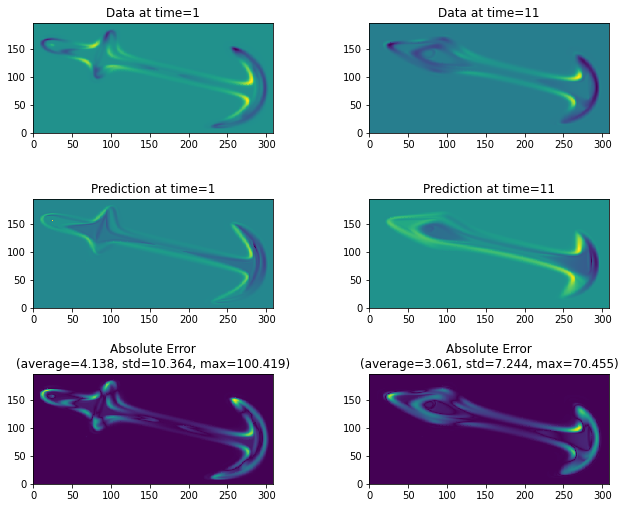

In [ ]:
#@title STLSQ (PDElib) Comparison of $\dot{u}$ and predicted $\dot{u}$

plt.figure(figsize=(10, 8))
plt.subplot(3, 2, 1, title='Data at time=' + str(test[0]))
plt.pcolor(X[:, :, 0], Y[:, :, 0], U_test_dot[:, :, 1, 0])
plt.subplot(3, 2, 2, title='Data at time=' + str(test[-1]))
plt.pcolor(X[:, :, 4], Y[:, :, 4], U_test_dot[:, :, len(test)-1, 0])

plt.subplot(3, 2, 3, title='Prediction at time=' + str(test[0]))
plt.pcolor(X[:, :, 0], Y[:, :, 0], u_dot_stlsq[:, :, 1, 0])
plt.subplot(3, 2, 4, title='Prediction at time=' + str(test[-1]))
plt.pcolor(X[:, :, 4], Y[:, :, 4], u_dot_stlsq[:, :, len(test)-1, 0])

tmp = abs(U_test_dot[:, :, 1, 0]-u_dot_stlsq[:, :, 1, 0])
plt.subplot(3, 2, 5, title='Absolute Error\n(average=%.3f, std=%.3f, max=%.3f)'%(tmp.mean(), tmp.std(), tmp.max()))
# plt.subplot(3, 2, 5, title='Absolute Error ' + str(tmp.mean()))
plt.pcolor(X[:, :, 0], Y[:, :, 0], tmp)
tmp = abs(U_test_dot[:, :, len(test)-1, 0]-u_dot_stlsq[:, :, len(test)-1, 0])
plt.subplot(3, 2, 6, title='Absolute Error\n(average=%.3f, std=%.3f, max=%.3f)'%(tmp.mean(), tmp.std(), tmp.max()))
plt.pcolor(X[:, :, 0], Y[:, :, 0], tmp)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.6)
plt.show()

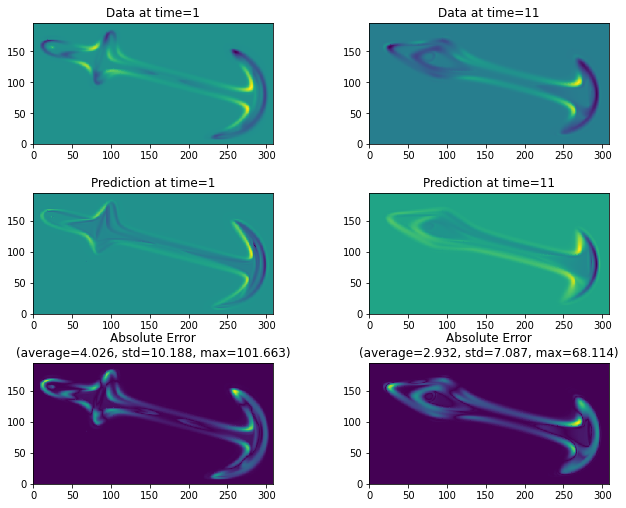

In [ ]:
#@title SR3 (GenLib) Comparison of $\dot{u}$ and predicted $\dot{u}$

plt.figure(figsize=(10, 8))
plt.subplot(3, 2, 1, title='Data at time=' + str(test[0]))
plt.pcolor(X[:, :, 0], Y[:, :, 0], U_test_dot[:, :, 1, 0])
plt.subplot(3, 2, 2, title='Data at time=' + str(test[-1]))
plt.pcolor(X[:, :, 4], Y[:, :, 4], U_test_dot[:, :, len(test)-1, 0])

plt.subplot(3, 2, 3, title='Prediction at time=' + str(test[0]))
plt.pcolor(X[:, :, 0], Y[:, :, 0], u_dot_sr3[:, :, 1, 0])
plt.subplot(3, 2, 4, title='Prediction at time=' + str(test[-1]))
plt.pcolor(X[:, :, 4], Y[:, :, 4], u_dot_sr3[:, :, len(test)-1, 0])

tmp = abs(U_test_dot[:, :, 1, 0]-u_dot_sr3[:, :, 1, 0])
plt.subplot(3, 2, 5, title='Absolute Error\n(average=%.3f, std=%.3f, max=%.3f)'%(tmp.mean(), tmp.std(), tmp.max()))
plt.pcolor(X[:, :, 0], Y[:, :, 0], tmp)
tmp = abs(U_test_dot[:, :, len(test)-1, 0]-u_dot_sr3[:, :, len(test)-1, 0])
plt.subplot(3, 2, 6, title='Absolute Error\n(average=%.3f, std=%.3f, max=%.3f)'%(tmp.mean(), tmp.std(), tmp.max()))
plt.pcolor(X[:, :, 0], Y[:, :, 0], tmp)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

# Outlook on SciML and mathematical expression discovery
## How it's been applied
- Equations that govern materials stability under environmental stress using PDE-FIND - [Naik et al. 2022](https://www.nature.com/articles/s41524-022-00751-5)
- Data-driven model discovery for ideal 4-wave mixing in non-linear fibre optics - [Ermolaev et al. 2022](https://www.nature.com/articles/s41598-022-16586-5)
- Quantifying nanoscale forces in dynamic atomic force microscopy - [Chandrashekar et al. 2022](https://pubs.rsc.org/en/content/articlehtml/2022/na/d2na00011c)
- Discovery of multiscale chemical reactions governed by the law of mass action - [Huang et al. 2022](https://www.sciencedirect.com/science/article/pii/S0021999121006380?casa_token=UqKqkwtuGKcAAAAA:Apzf0gTOjxjwOdDLSnNrxKdMHFLTyWPoKKx1_ACkPKh-AQIJNzkhd27BQjLrLrRWohZpq7M63WM)


## Developments
### Symbolic Regression Related
- Symbolic regression based on weak formulation using appropriate physical constraints (locality, smoothness, symmetries) - [Reinbold et al. 2021](https://www.nature.com/articles/s41467-021-23479-0)
- Symbolic regression via Neural-Guided Genetic Programming Population Seeding (using RL policies to learn probabilities of performing the different genetic operations) - [Mundhenk et al. 2021](https://arxiv.org/abs/2111.00053)
- Deep learning genetic algorithm for PDE discovery (DLGA-PDE) combines titular two methods such that an incomplete candidate library can be used [Xu et al 2020](https://www.sciencedirect.com/science/article/pii/S0021999120303582)
### SINDy related
- Weak SINDy based on Galerkin (potential speedups to the currently implemented weakPDE library; no performance comparison currently existing) - [Messenger and Bortz 2021](https://epubs.siam.org/doi/abs/10.1137/20M1343166)
- Runge-Kutta inspired dictionary-based sparse regression (effective for corrupted/sparsely sampled data) - [Goyal and Benner 2022](https://royalsocietypublishing.org/doi/full/10.1098/rspa.2021.0883)
- Autodiff SINDy to simultaneously denoise data, learn and parametrize noise probability distribution, and identify the parsimonious dynamical system - [Kaheman et al. 2022](https://iopscience.iop.org/article/10.1088/2632-2153/ac567a/meta)
### Larger changes/New architectures
- PDE-Net 2.0 which uses wavelet theory to generate convolution kernels which then can approximate derivatives in chains of time step network blocks. Ties NNs with computational mathematics to solve such problems and attempts to maintain prediction accuracy and/or expressive power but *also* with a major focus on being transparent enough to reveal the actual/symbolic PDE model [Long et al. 2019](https://arxiv.org/abs/1812.04426)
- Parsimonious neural networks combining NNs with evolutionary optimization - [Desai and Strachan 2021](https://www.nature.com/articles/s41598-021-92278-w)
- Combining SINDy with deep delay autoencoders to account for latent variables not directly measured but dynamically important (based on Takens' theorem wherein partial measurements can be augmented with time delayed information) - [Bakarji et al. 2022](https://iopscience.iop.org/article/10.1088/2632-2153/ac567a/meta)
- Bayesian approach to data-driven dynamic equation discovery to attempt to account for observational uncertainty and parameter uncertainty - [North et al. 2022](https://link.springer.com/article/10.1007/s13253-022-00514-1)
- Kernel approach for PDE discovery and operator learning (can be paired with SINDy to stabilize and also enable operator learning) - [Long et al. 2022](https://arxiv.org/abs/2210.08140)

## Unfinished attempt at using the model to simulate the PDE (WIP, does not work currently)

100%|██████████| 20000/20000 [01:00<00:00, 329.00it/s]


Text(0.5, 1.0, 'Basic reconstruction')

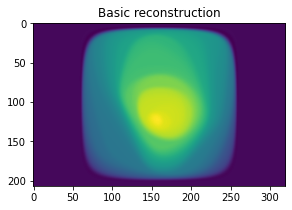

In [ ]:
from google.colab import files as FILE
import requests
import os

img_data = requests.get('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTAH5wyjbxzaukyJ6bZEiBJeARR7Kw0nzfsgg&usqp=CAU').content
with open('image_0002.jpg', 'wb') as handler:
    handler.write(img_data)

# FILE.download('image_0002.jpg')

myImg = Image.open('image_0002.jpg')
width, height = myImg.size   # Get dimensions

left = (width - 310)/2
top = (height - 197)/2
right = (width + 310)/2
bottom = (height + 197)/2

# Crop the center of the image
myImg = myImg.crop((left, top, right, bottom))
myImg = np.array(ImageOps.grayscale(myImg))
myImg = np.pad(myImg,5) / myImg.max()

Lx = myImg.shape[1]
Ly = myImg.shape[0]
dt = 1e-3
ops = {'dx':100/min(myImg.shape), 'Tmax':20, 'frames':12}
u, t, U = computeFlow(myImg, dt=dt, **ops)
plt.figure(figsize=(15,3))
plt.imshow(u); plt.title('Basic reconstruction')

In [ ]:
Lx

In [ ]:
newU = np.zeros((U.shape[2], U.shape[1], U.shape[0], 1))
newU[:,:,:,0] = U.transpose()
train = np.random.choice(U.shape[0], int(U.shape[0] * 0.6), replace=False)
test = [i for i in np.arange(U.shape[0]) if i not in train]

U_dot = ps.FiniteDifference(axis=2)._differentiate(newU, dt)

U_train = newU[:, :, train, :]
U_test = newU[:, :, test, :]
U_train_dot = U_dot[:, :, train, :]
U_test_dot = U_dot[:, :, test, :]
t_train = t_captured[train]
t_test = t_captured[test]
tmp = model.predict(U_test)
tmp = np.reshape(tmp, (U.shape[2], U.shape[1], len(t_test), 1))
plt.pcolor(X[:, :, 0], Y[:, :, 0], tmp[:, :, 1, 0])

ValueError: ignored

In [ ]:
t_sampling = np.linspace(0,100-1,100)
tmp = np.zeros((myImg.shape[1], myImg.shape[0], 1))
tmp[:,:,0] = myImg.transpose()

result = model.simulate(myImg,t_sampling)

plt.figure(figsize=(10, 8))
# plt.subplot(3, 2, 1, title='Data at time=' + str(test[0]))
plt.pcolor(X[:, :, 0], Y[:, :, 0], result[:, :, 1, 0])